## Preliminary study

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from glob import glob

from scipy.signal import resample

In [47]:
path_dir = r"C:\Users\Shootall\Documents\rPPG-dataset\thai_ipad_reconstructed_seg1"
path_list = glob(os.path.join(path_dir, "*.pkl"))

In [48]:
for path_pkl in path_list:
    data_df = np.load(path_pkl, allow_pickle=True)
    break

In [49]:
recon_rppg = data_df['reconstructed_rppg']
recon_rppg = recon_rppg[~np.isnan(recon_rppg[:,0]),:]
roi_list = data_df['roi']
print(roi_list)

['roi-forehead', 'roi-left_cheek', 'roi-right_cheek', 'roi-chin', 'roi-glabella']


In [50]:
N_len = recon_rppg.shape[0]
x = resample(recon_rppg[:N_len-N_len%10,0], N_len//10)
y = resample(recon_rppg[:N_len-N_len%10,1], N_len//10)

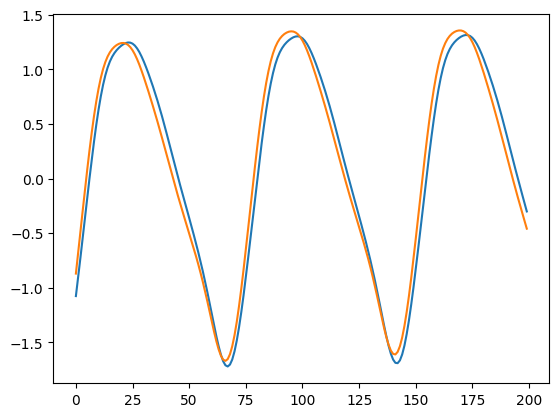

In [51]:
plt.plot(x[2000:2200])
plt.plot(y[2000:2200])

Frequency bins: [1.34899913 1.37510879 1.38381201 1.39251523 1.40992167 1.41862489
 1.42732811]Hz, 
Phase: [-0.1438467  -0.1445932  -0.14895245 -0.14751245 -0.14381809 -0.1462891
 -0.1436224 ], 
Estimated time delay: 23.982ms


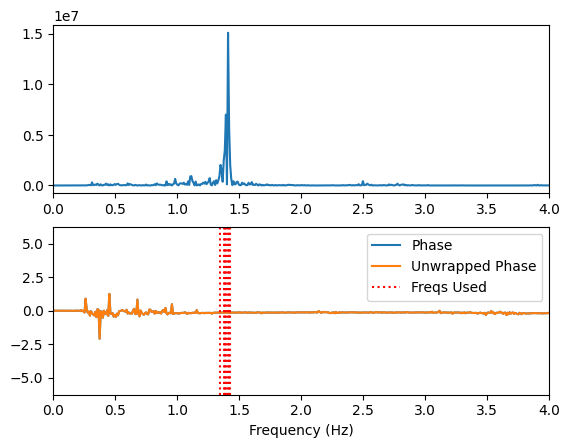

In [52]:
fs = 100
N = len(x)
X = np.fft.rfft(x)
Y = np.fft.rfft(y)
# Assume we have cross-spectrum from earlier FFTs: cross_spec = X * np.conj(Y)
cross_spec = X * np.conj(Y)  # from previous example or computed elsewhere
freqs = np.fft.rfftfreq(N, d=1.0/fs)  # frequency axis (Fs = sampling rate)
phase = np.angle(cross_spec)
phase_unwrapped = np.unwrap(phase)

# Optionally select frequency range of interest:
# e.g., use only frequencies where |cross_spec| is significant 
mask = np.abs(cross_spec) > np.max(np.abs(cross_spec)) * 0.1  # example threshold
freqs_used = freqs[mask]
phase_used = phase_unwrapped[mask]

plt.subplot(2,1,1)
plt.plot(freqs, np.abs(cross_spec))
plt.xlim([0, 4])

plt.subplot(2,1,2)
plt.plot(freqs, phase, label='Phase')
plt.plot(freqs, phase_unwrapped, label='Unwrapped Phase')

# Plot red dotted lines for each frequency in freqs_used
for i, f_used in enumerate(freqs_used):
    if i == 0: # Add label only for the first line to avoid cluttering the legend
        plt.axvline(x=f_used, color='red', linestyle='dotted', label='Freqs Used')
    else:
        plt.axvline(x=f_used, color='red', linestyle='dotted')
plt.xlabel('Frequency (Hz)')
plt.xlim([0,4])
plt.ylim([-2*np.pi, 2*np.pi])
plt.legend()

if len(freqs_used) > 0:
    # Fit a line to phase_used vs freqs_used
    coeffs = np.polyfit(freqs_used, phase_used, 1)  # returns [slope, intercept]
    slope = coeffs[1]
    tau_est = -slope / (2*np.pi)
else:
    # If no frequencies are used, estimate tau from the first frequency and pha
    tau_est = phase_used[0]/(2*np.pi*freqs_used[0])

print(f"Frequency bins: {freqs_used}Hz, \nPhase: {phase_used}, \nEstimated time delay: {tau_est*1000:.3f}ms")

In [53]:
x = x[:1024]
y = y[:1024]

In [54]:
xy = np.column_stack((x,y))
xy -= np.mean(xy, axis=0)
xy.shape

(1024, 2)

In [55]:
XY = np.fft.rfft(xy, axis=0)
COV = XY.conj().T @ XY

In [56]:
v, vec = np.linalg.eigh(COV)

In [59]:
(np.angle(vec[-1,-1]) - np.angle(vec[0, -1]))/(2*np.pi)

np.float64(-0.022384973209750116)

## Simulation

- HR: 60, 90, 120 bpm
- delay: -50~50ms
- noise_level: 0.1, 0.3, 0.5

In [1]:
import neurokit2 as nk
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def delay_signal(signal, delay_ms, fs):
    """
    Apply a fractional delay to a 1D signal using interpolation.

    Parameters:
    - signal: np.ndarray, input signal
    - delay_ms: float, desired delay in milliseconds
    - fs: float, sampling frequency (Hz)

    Returns:
    - delayed_signal: np.ndarray
    """
    T = 1 / fs
    delay_s = delay_ms / 1000.0
    delay_samples = delay_s * fs

    n = np.arange(len(signal))
    f_interp = interp1d(n, signal, kind='cubic', fill_value='extrapolate')
    delayed_n = n - delay_samples  # shift left
    delayed_signal = f_interp(delayed_n)
    return delayed_signal

In [31]:
# Fixed parameters
fs = 60
t = 25

freq_mod = 0.2
ibi_randomness = 0.1
motion_amplitude=0.1
random_state_fix = 42

# Variable parameters
hr_list = [60, 90, 120]
delay_list = np.arange(-50,50) # ms
noise_level = [0.08, 0.16, 0.32]

# Simulation
ts = np.arange(0, t, 1/fs)

for hr_ in hr_list:
    for delay_ in delay_list:
        for noise_ in noise_level:
            # Generate PPG signal
            configs = {
                "frequency_modulation": freq_mod,
                "ibi_randomness": ibi_randomness,
                "motion_amplitude": motion_amplitude,
                "random_state": random_state_fix,
            }
            ppg = nk.ppg_simulate(duration=t, sampling_rate=fs, heart_rate=hr_, **configs)
            delayed_ppg = delay_signal(ppg, delay_ms=delay_, fs=fs)
            delayed_ppg = np.clip(delayed_ppg, np.min(ppg), np.max(ppg))
            delayed_ppg = nk.signal_distort(delayed_ppg, sampling_rate=fs, noise_shape='laplace', noise_amplitude=noise_, noise_frequency=fs/10)
            break
        break
    break

In [ ]:
import importlib
time_delay_estimation = importlib.import_module('time_delay_estimation')
time_delay_estimation = importlib.reload(time_delay_estimation)
sinc_interp = getattr(time_delay_estimation, 'sinc_interp')
peak_ptt = getattr(time_delay_estimation, 'peak_ptt')

In [86]:
delay_ = -49
ppg = nk.ppg_simulate(duration=t, sampling_rate=fs, heart_rate=hr_, **configs)
delayed_ppg = delay_signal(ppg, delay_ms=delay_, fs=fs)
delayed_ppg = np.clip(delayed_ppg, np.min(ppg), np.max(ppg))
delayed_ppg = nk.signal_distort(delayed_ppg, sampling_rate=fs, noise_shape='laplace', noise_amplitude=noise_, noise_frequency=fs/10)

delay, corr = sinc_interp(ppg, delayed_ppg, fs, scale_factor=16)
pkptt = peak_ptt(ppg, delayed_ppg, ts, )
print(f"GT delay: {delay_/1000} \nPeak detection: {pkptt} \nCorrelation: {delay}")

GT delay: -0.049 
Peak detection: -0.04652777777777712 
Correlation: 0.04895833333333333


-0.049 -0.009375


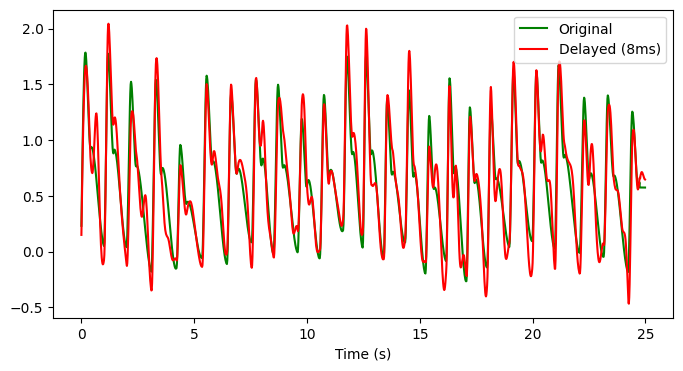

In [22]:
ppg = nk.ppg_simulate(duration=t, sampling_rate=fs, heart_rate=60, **configs)
delayed_ppg = delay_signal(ppg, delay_ms=8, fs=fs)
delayed_ppg = np.clip(delayed_ppg, np.min(ppg), np.max(ppg))
delayed_ppg = nk.signal_distort(delayed_ppg, sampling_rate=fs, noise_shape='laplace', noise_amplitude=0.32, noise_frequency=fs/10)

plt.figure(figsize=(8,4))
plt.plot(ts, ppg, label='Original', color='g')
plt.plot(ts, delayed_ppg, label='Delayed (8ms)', color='r',)
plt.legend()
# plt.title("Fractional Delay Example (8ms)")
plt.xlabel("Time (s)")
plt.show()
